# Devils DFTD 2-Stage Infection

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../../GillesPy2')))

In [2]:
import time
import json
import pickle

In [3]:
from gillespy2 import TauHybridCSolver

In [4]:
from dask.distributed import Client
from dask import delayed

In [5]:
from Devils_DFTD_2_Stage_Infection import DevilsDFTD2StageInfection
from Simulation import Simulation, devil_pop
from ParameterSweep import ParameterSweep

In [6]:
# c = Client(n_workers=8, threads_per_worker=1)
c = Client("james.cs.unca.edu:12345")

/opt/homebrew/lib/python3.9/site-packages/distributed/client.py:1265: VersionMismatchWarning: Mismatched versions found

+---------+---------------+----------------+----------------+
| Package | client        | scheduler      | workers        |
+---------+---------------+----------------+----------------+
| python  | 3.9.9.final.0 | 3.8.10.final.0 | 3.8.10.final.0 |
+---------+---------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


## With Immunity Intervention
### Load existing state

In [7]:
immun_state_path = "./DevilsDFTD2StageInfectionWithImmunityState.p"
if os.path.exists(immun_state_path):
    with open(immun_state_path, "rb") as immun_state_file:
        immun_state = pickle.load(immun_state_file)
    
    # Model
    immun_model = immun_state['model']
    # Simulation
    immun_sim = Simulation.load_state(immun_state['sim'])
    # Parameter Sweep Job
    immun_job = ParameterSweep.load_state(immun_state['job'])
else:
    immun_state = None
    print("No existing immunity state found.")
    
    # Model
    immun_model = DevilsDFTD2StageInfection(devil_pop, interventions="immunity")
    # Simulation
    immun_sim = Simulation(model=immun_model)
    # Parameter Sweep Job
    immun_job = ParameterSweep(model=immun_model)

### Solver

In [8]:
immun_sol = delayed(TauHybridCSolver)(model=immun_model, variable=True)

### Simulation

In [9]:
immun_sim.configure(solver=immun_sol)
%time _ = immun_sim.run(use_existing_results=True)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.06 µs


In [10]:
immun_sim.output_dftd_devils_probs(print_probs=True)

DFTD elimination: 100%
Devil extinction: 0%


### Visualize Simulation Results

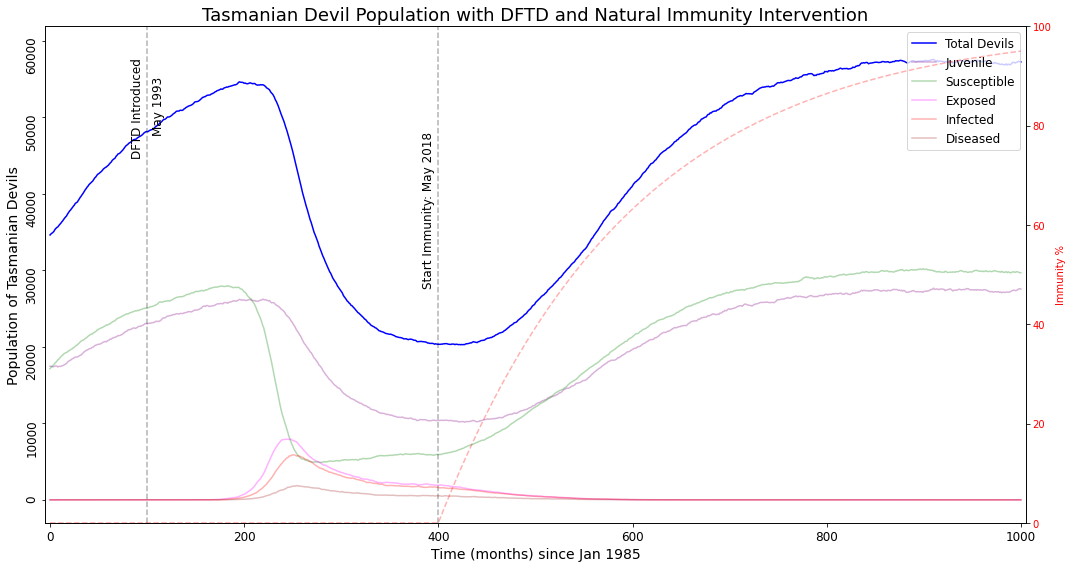

In [11]:
immun_sim.plot()

### Parameter Sweep

In [12]:
immun_params = [
    {"parameter": "immunity_growth_rate", "range": [0.005, 0.0075, 0.01]},
#     {"parameter": "immunity_growth_rate", "range": [0.0075, 0.01, 0.0125]},
    {"parameter": "immunity_max_level", "range": [50, 70, 100]},
    {"parameter": "immunity_start", "range": [384, 444, 504]}
]

In [13]:
new_params = immun_job.params != immun_params
%time immun_job.run(solver=immun_sol, params=immun_params)

CPU times: user 1.43 ms, sys: 114 µs, total: 1.54 ms
Wall time: 122 µs


### Visualize Parameter Sweep Results

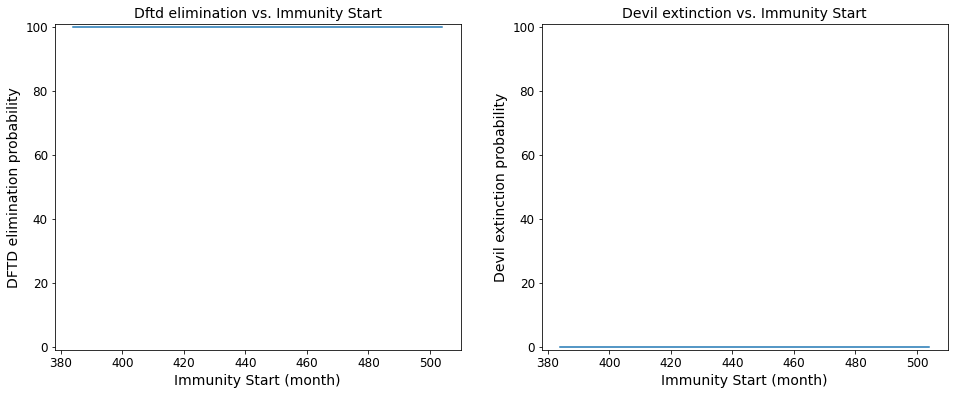

In [14]:
# res_sub_keys = ["immunity_max_level:100", "immunity_growth_rate:0.01"]
res_sub_keys = ["immunity_growth_rate:0.01"]
immun_job.plot_devil_dftd_extinction_over_param(
    res_sub_keys=res_sub_keys, key="immunity_start", param_label="Immunity Start", units="month"
)

In [15]:
immun_job.explore_results()

Output()

### Store Immunity State

In [16]:
immun_state = {"model": immun_model, "sim":immun_sim, "job":immun_job}
with open(immun_state_path, "wb") as immun_state_file:
    pickle.dump(immun_state, immun_state_file)

## With Vaccination Intervention
### Load existing state

In [17]:
vacc_state_path = "./DevilsDFTD2StageInfectionWithVaccinationState.p"
if os.path.exists(vacc_state_path):
    with open(vacc_state_path, "rb") as vacc_state_file:
        vacc_state = pickle.load(vacc_state_file)
        
    # Model
    vacc_model = vacc_state['model']
    # Simulation
    vacc_sim = Simulation.load_state(vacc_state['sim'])
    # Parameter Sweep Job
    vacc_job = ParameterSweep.load_state(vacc_state['job'])
else:
    vacc_state = None
    print("No existing vaccination state found.")

    # Model
    vacc_model = DevilsDFTD2StageInfection(devil_pop, interventions="vaccination")
    # Simulation
    vacc_sim = Simulation(model=vacc_model)
    # Parameter Sweep Job
    vacc_job = ParameterSweep(model=vacc_model)

### Solver

In [18]:
vacc_sol = delayed(TauHybridCSolver)(model=vacc_model, variable=True)

### Simulation

In [19]:
vacc_sim.configure(solver=vacc_sol)
%time _ = vacc_sim.run(use_existing_results=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [20]:
vacc_sim.output_dftd_devils_probs(print_probs=True)

DFTD elimination: 0%
Devil extinction: 0%


### Visualize Simulation Results

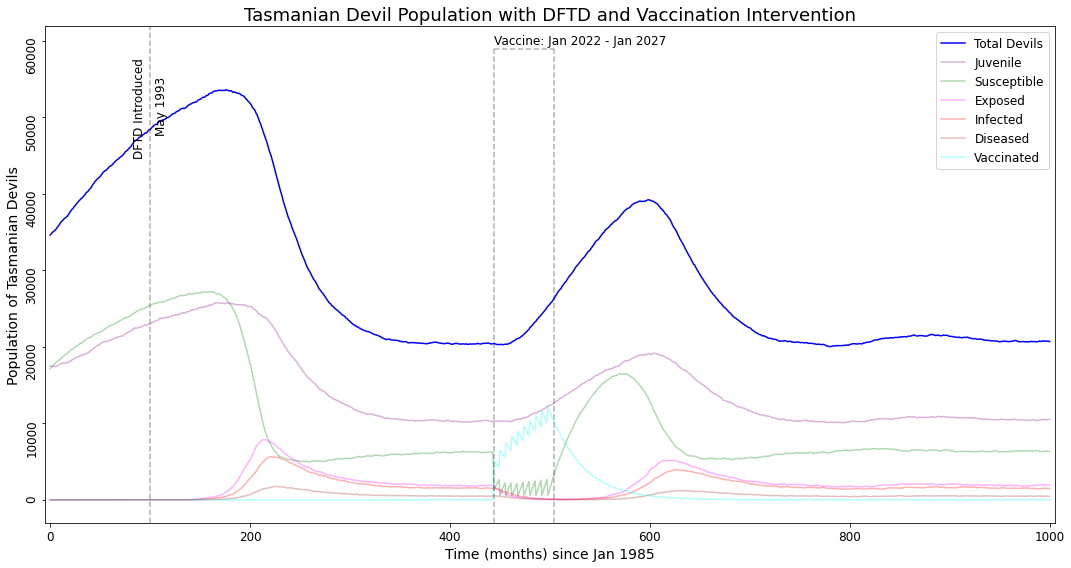

In [21]:
vacc_sim.plot()

### Parameter Sweep

In [22]:
params = [
    {"parameter": "vaccinated_infection_rate", "range": [0.1, 0.2, 0.4, 0.6]},
    {"parameter": "vaccination_proportion", "range": [0.6, 0.8, 1.0]},
    {"parameter": "vacc_program_length", "range": [3, 5, 6, 7, 8, 9, 10, 11]},
    {"parameter": "vaccine_frequency", "range": [2, 4, 6]}
]

In [23]:
%time vacc_job.run(solver=vacc_sol, params=params)

CPU times: user 2.52 ms, sys: 392 µs, total: 2.92 ms
Wall time: 860 µs


### Visualize Parameter Sweep Results

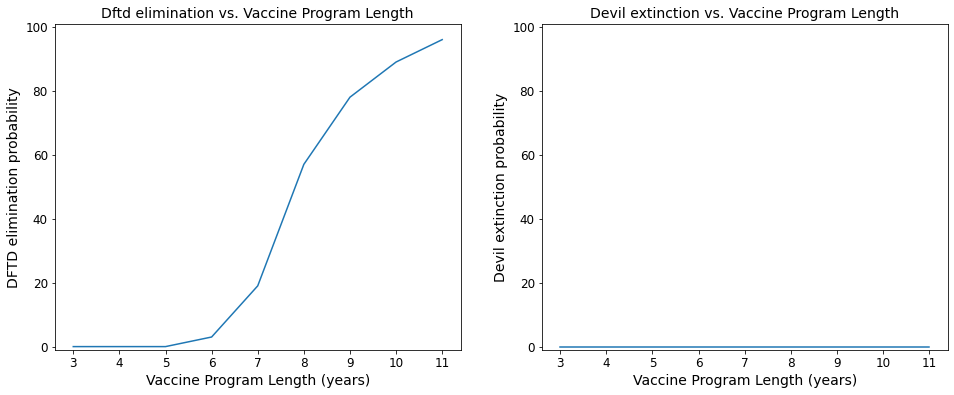

In [24]:
res_sub_keys=["vaccine_frequency:6", "vaccination_proportion:0.8", "vaccinated_infection_rate:0.6"]
vacc_job.plot_devil_dftd_extinction_over_param(
    res_sub_keys=res_sub_keys, key="vacc_program_length", param_label="Vaccine Program Length", units="years"
)

In [25]:
vacc_job.explore_results()

Output()

### Store Vaccination State

In [26]:
vacc_state = {"model": vacc_model, "sim":vacc_sim, "job":vacc_job}
with open(vacc_state_path, "wb") as vacc_state_file:
    pickle.dump(vacc_state, vacc_state_file)

## With Culling Intervention
### Load existing state

In [27]:
cull_state_path = "./DevilsDFTD2StageInfectionWithCullingState.p"
if os.path.exists(cull_state_path):
    with open(cull_state_path, "rb") as cull_state_file:
        cull_state = pickle.load(cull_state_file)
        
    # Model
    cull_model = cull_state['model']
    # Simulation
    cull_sim = Simulation.load_state(cull_state['sim'])
    # Parameter Sweep Job
    cull_job = ParameterSweep.load_state(cull_state['job'])
else:
    cull_state = None
    print("No existing vaccination state found.")

    # Model
    cull_model = DevilsDFTD2StageInfection(devil_pop, interventions="culling")
    # Simulation
    cull_sim = Simulation(model=cull_model)
    # Parameter Sweep Job
    cull_job = ParameterSweep(model=cull_model)

### Solver

In [28]:
cull_sol = delayed(TauHybridCSolver)(model=cull_model, variable=True)

### Simulation

In [29]:
cull_sim.configure(solver=cull_sol)
%time _ = cull_sim.run(use_existing_results=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [30]:
cull_sim.output_dftd_devils_probs(print_probs=True)

DFTD elimination: 0%
Devil extinction: 0%


### Visualize Simulation Results

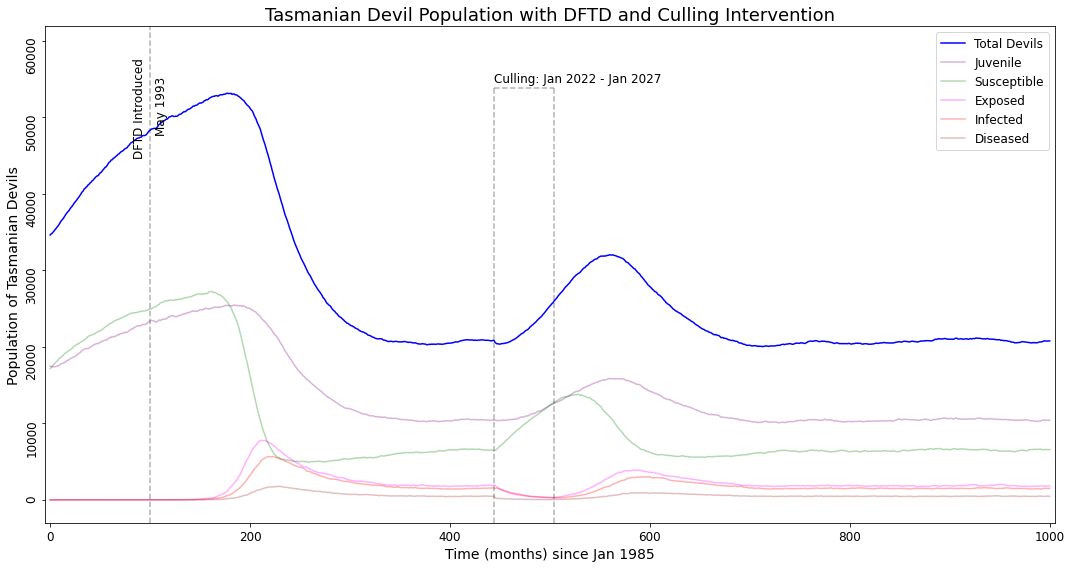

In [31]:
cull_sim.plot()

### Parameter Sweep

In [32]:
params = [
    {"parameter": "cull_rate_diseased", "range": [0.25, 0.5, 0.75]},
    {"parameter": "cull_program_length", "range": [3, 5, 6, 7, 8, 9, 10, 11]}
]

In [33]:
new_params = cull_job.params != params
%time cull_job.run(solver=cull_sol, params=params)

CPU times: user 1.01 ms, sys: 374 µs, total: 1.38 ms
Wall time: 210 µs


### Visualize Parameter Sweep Results

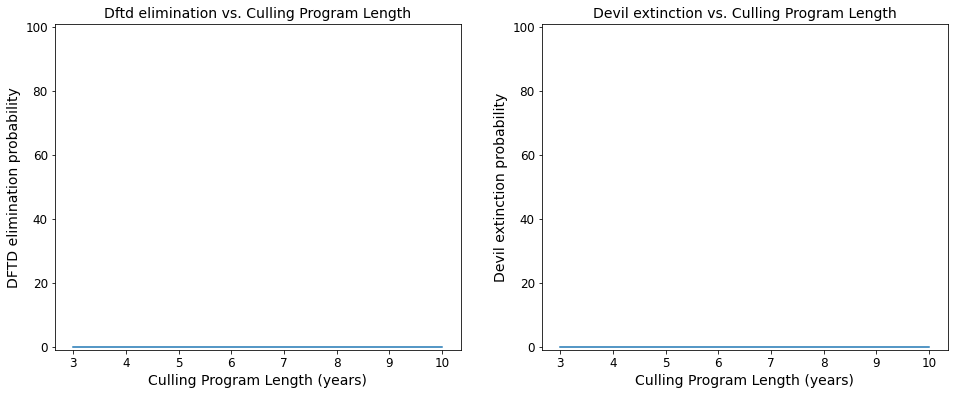

In [34]:
res_sub_keys = ["cull_rate_diseased:0.5"]
cull_job.plot_devil_dftd_extinction_over_param(
    res_sub_keys=res_sub_keys, key="cull_program_length", param_label="Culling Program Length", units="years"
)

In [35]:
cull_job.explore_results()

Output()

### Store Culling State

In [36]:
cull_state = {"model": cull_model, "sim":cull_sim, "job":cull_job}
with open(cull_state_path, "wb") as cull_state_file:
    pickle.dump(cull_state, cull_state_file)